# Mask R-CNN - Inspect MICCAI Dataset

This notebook shows some elements of MICCAI16 dataset

In [1]:
import os
import sys
import datetime
import numpy as np
import skimage.draw
import SimpleITK as sitk
import matplotlib.pylab as plt
from imgaug import augmenters as iaa



# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn import visualize
from mrcnn.visualize import display_images

# Path to trained weights file
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_WEIGHTS_PATH):
    utils.download_trained_weights(COCO_WEIGHTS_PATH)
    

MICCAI16_WEIGHTS_PATH = os.path.join(ROOT_DIR, "logs/MICCAI/mask_rcnn_miccai_0036.h5")
WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")


Using TensorFlow backend.


# Configuration

In [2]:

class MiccaiConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "Miccai"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 5

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + 1 Lesion

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 400

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 384
    
    # Image mean (RGB)
    MEAN_PIXEL = np.array([0.13, 0.13, 0.13])
    
    # BACKBONE_STRIDES for computing feature map size
    
    # Length of square anchor side in pixels
    #RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56) 
    
class MiccaiInferenceConfig(MiccaiConfig):
    # Set batch size to 1 to run one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # Non-max suppression threshold to filter RPN proposals.
    RPN_NMS_THRESHOLD = 0.7
config = MiccaiConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     5
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 5
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  384
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Dataset

Load Miccai dataset

Override the following methods:

* load_image()
* load_mask()
* image_reference()

In [3]:
from skimage import measure
from tools import separate_mask

class MiccaiDataset(utils.Dataset):
    
    def load_miccai_dataset(self, dataset_dir,subset):
        """Load a subset of the dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have 1 classe and backround is initialized per default
        self.add_class("Miccai", 1, "Lesion")
        
        assert subset in ["train", "validation", "test"]
        
        dataset_dir = os.path.join(dataset_dir, "Miccai_example_data")
        
        image_ids = []
        
        # r=root, d=directories, f = files
        for r, d, f in os.walk(dataset_dir):
            for file in f:    
                if '3DFLAIR' in file:
                    image_ids.append(os.path.join(r, file))

        nb_image = len(image_ids)
        
        print("nombre image 2D : ", nb_image)

        for image_id in image_ids:
            img_name = os.path.basename(image_id)
            self.add_image(
                "Miccai",
                image_id=img_name[len("3DFLAIR_"):len(img_name)-len(".nii.gz")],
                path=image_id)

            
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        #dataset_dir = os.path.join(os.path.dirname(info['path']), "Consensus.nii.gz")
        image_info = self.image_info[image_id]
        #print("image_info = ", image_info)
        
        img_name = os.path.dirname(image_info['path'])
        #print("info id ", image_info['id'])
        #print("info path ", image_info['path'])
        mask_id = os.path.join(os.path.dirname(image_info['path']), "Consensus_" + 
                               str(image_info['id']) + ".nii.gz")
    
        #mask_id = os.path.join(os.path.dirname(image_info['path']), "Consensus_"+(image_info['id'][8:11])+".nii.gz")
        #print("mask id = ", mask_id)
            
        
        mask=sitk.GetArrayFromImage(sitk.ReadImage(mask_id, sitk.sitkUInt8))
        #sitkFloat32))
        
        num_pixel_treshold = 20
        mask = separate_mask(mask, num_pixel_treshold)
        
        count_non_zero = np.count_nonzero(mask) 

        if count_non_zero < num_pixel_treshold:
            # no mask
            mask = np.zeros((mask.shape[0], mask.shape[1], 1))
            class_ids = np.zeros(1, np.int32)
            #print("no mask")
            #print("class_ids = ", class_ids.shape)
        
        else:
            class_ids = np.ones([mask.shape[-1]], dtype=np.int32)
            #print("class_ids = ", class_ids.shape)
        
        #print("mask shape = ", mask.shape)
        #print("class_ids = ", class_ids.shape)
        
        #for i in range(0, class_ids.shape[0]):
         #   plt.figure()
          #  plt.imshow(mask[:,:,i], cmap='gray')
           # plt.axis('off')
            #plt.show()
        
        return mask.astype(np.bool), class_ids
        
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "Miccai":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)
    
    def load_image (self, image_id):
        #print("load image")
        # we can use next image_reference function instead of image_info
        #print("path image id = ", self.image_info[image_id]['path'])
        image=sitk.GetArrayFromImage(sitk.ReadImage(self.image_info[image_id]['path'], sitk.sitkFloat32))

        image[image < 0] = 0

        image=np.stack((image,image,image),axis=2)
        
        #plt.figure()
        #plt.imshow(image, cmap='gray')
        #plt.axis('off')
        #plt.show()
        
        #print("shape image before returning : ", image.shape)
        # mean pixels in all dataset :  0.13044332
        # std pixels in all dataset :  0.28245687

        return image



**Load dataset and apply data augmentation**


In [4]:
# Training dataset.
dataset_dir = "/floyd/input"

# Test dataset
dataset_test = MiccaiDataset()
dataset_test.load_miccai_dataset(dataset_dir, "test")
dataset_test.prepare()

print("Image Count: {}".format(len(dataset_test.image_ids)))
print("Class Count: {}".format(dataset_test.num_classes))
for i, info in enumerate(dataset_test.class_info):
    print("{:3}. {:50}".format(i, info['name']))

augmentation = iaa.SomeOf((0, 2), [
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.OneOf([iaa.Affine(rotate=90),
            iaa.Affine(rotate=180),
            iaa.Affine(rotate=270)]),
    iaa.Multiply((0.8, 1.5)),
    iaa.GaussianBlur(sigma=(0.0, 5.0))
])

dataset = dataset_test

nombre image 2D :  1525
taille train:  915
taille valid:  305
taille test:  305
Image Count: 915
Class Count: 2
  0. BG                                                
  1. Lesion                                            


## Dataset

In [5]:
image = sitk.ReadImage("/floyd/input/miccai_preprocess/01016SACH/3DFLAIR_194.nii.gz")
#print("Pixel Type    {}".format(image.GetPixelID()))
#print("Size          {}".format(image.GetSize()))
#print("Origin        {}".format(image.GetOrigin()))
print("Spacing       {}".format(image.GetSpacing()))
#print("Direction     {}".format(image.GetDirection()))

Spacing       (1.0, 1.0)


In [32]:
means = []
img = []

for image_id in dataset.image_ids:
    #print("image id ", image_id)
    image = dataset.load_image(image_id)
    #mask, _ = dataset_test.load_mask(image_id)
    #bbox = utils.extract_bboxes(mask)
    # Sanity check
    #assert mask.shape[:2] == image.shape[:2]
    #mean_pixel = np.mean(image, axis=(0, 1))
    #print("mean pixel image = ", mean_pixel)
    means.append(np.mean(image, axis=(0, 1)))
    img.append(image[:,:,0])

means = np.array(means)
print("shape of means : ", means.shape)
print("mean pixels in all dataset : ", np.mean(means))
# mean pixels in all dataset :  0.13044332

img = np.array(img)
print("shape of img : ", img.shape)
print("std pixels in all dataset : ", np.std(img))
# std pixels in all dataset :  0.28245687

shape of means :  (1525, 3)
mean pixels in all dataset :  0.13044332
shape of img :  (1525, 336, 336)
std pixels in all dataset :  0.28245687


**Afficher les masks d'une image**

[ 19 194 787 853]
19
(2,)


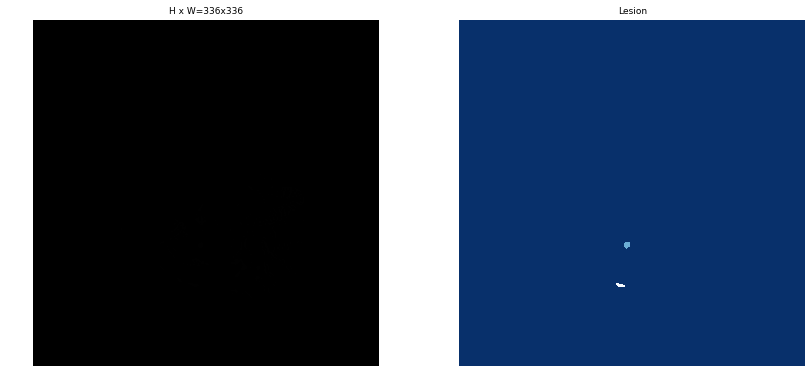

194
(1,)


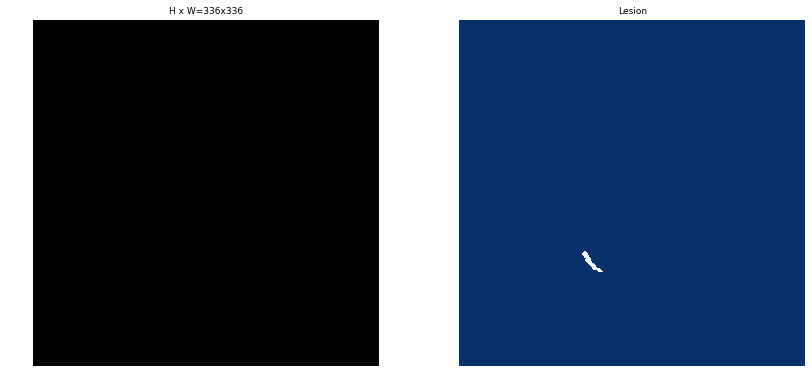

787
(2,)


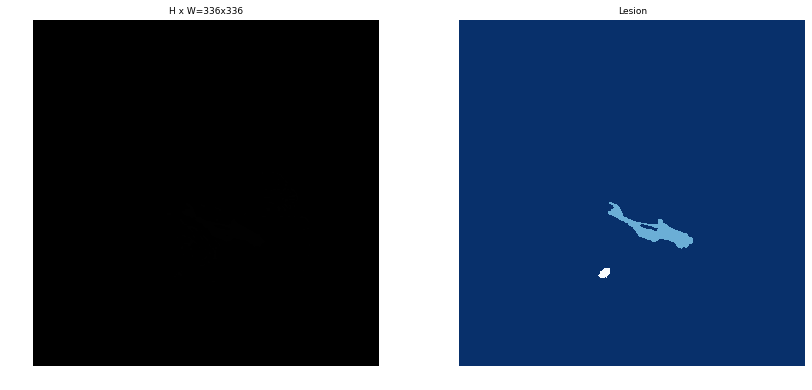

853
(3,)


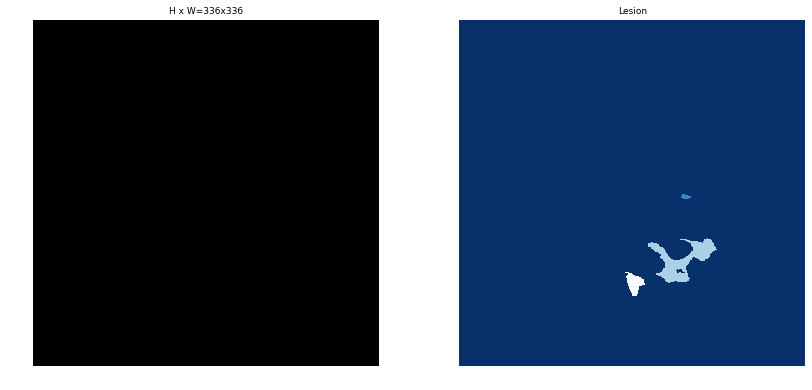

In [7]:
# Afficher les masks
image_ids = np.random.choice(dataset.image_ids, 4)
#print(dataset_train.image_ids)
print(image_ids)
# for seeing images, user must edit file visualize.py in mrcnn folder
# line 53 in display image function, he must edit this line:
# plt.imshow(image.astype(np.uint8), cmap=cmap,
# by:
# plt.imshow(image.astype(np.float32), cmap=cmap,

for image_id in image_ids:
    print(image_id)
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    print(class_ids.shape)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=1)

**Afficher les différents bbox d'un même mask**

image_id:  473 /floyd/input/miccai_preprocess/07003SATH/3DFLAIR_144.nii.gz
image                    shape: (336, 336, 3)         min:    0.00000  max:    1.30769  float32
mask                     shape: (336, 336, 7)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (7,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (7, 4)                min:  101.00000  max:  300.00000  int32


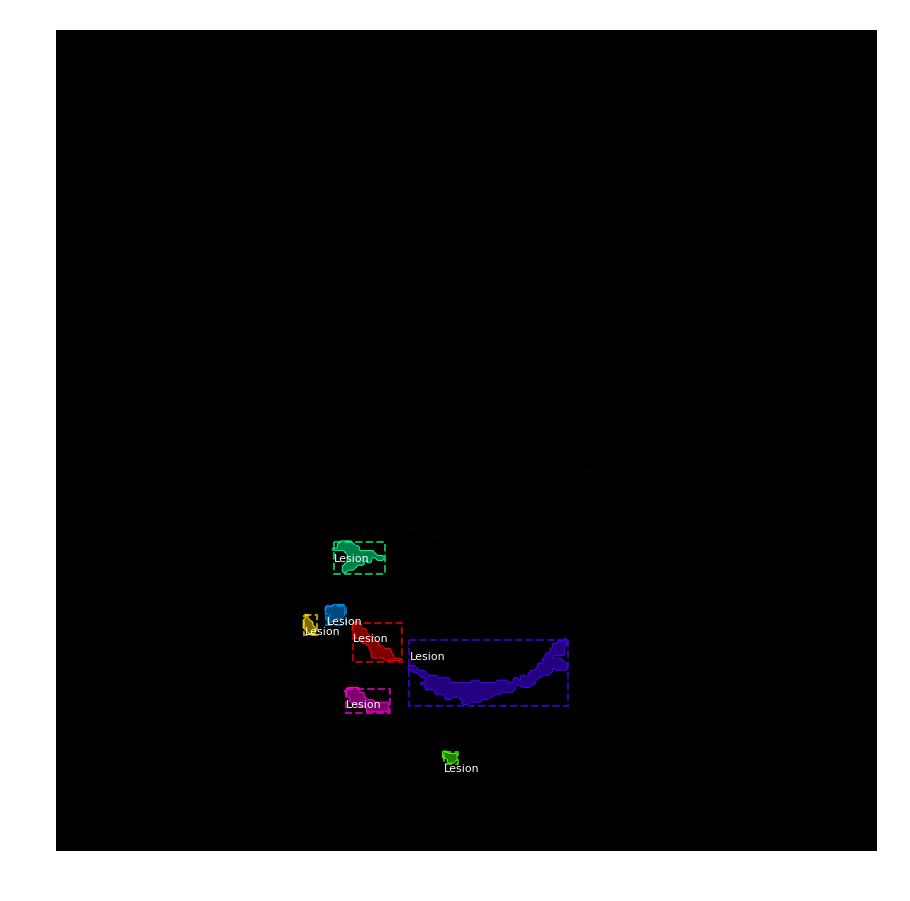

In [8]:
# Afficher les différents bbox
from mrcnn.model import log

# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 4)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)

# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

**Afficher pour une même image, les masques séparés sur plusieurs figures différentes**

288
image                    shape: (384, 384, 3)         min:    0.00000  max:    1.50241  float32
image_meta               shape: (14,)                 min:    0.00000  max:  384.00000  float64
class_ids                shape: (4,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (4, 4)                min:  130.00000  max:  338.00000  int32
mask                     shape: (56, 56, 4)           min:    0.00000  max:    1.00000  bool


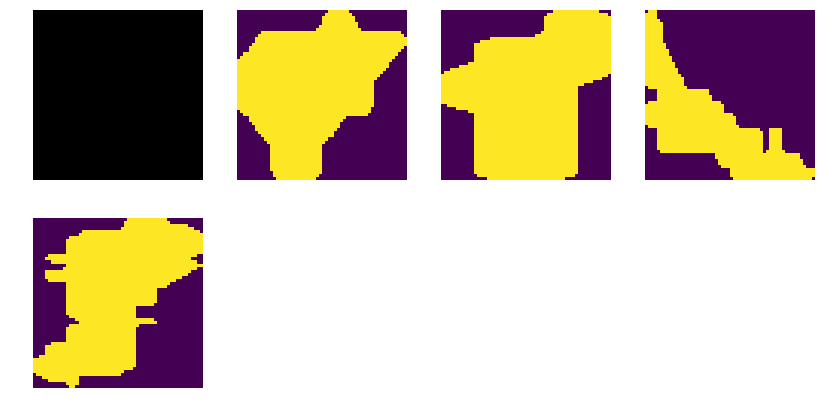

In [11]:
# Afficher les masques séparés
# nombre de figures sur lesquelles afficher les différents masks séparés
nb_fig = 20

image_id = np.random.choice(dataset.image_ids, 1)[0]
#image_id=1111
print(image_id)
#image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
 #   dataset, config, image_id, use_mini_mask=False)
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], nb_fig))])

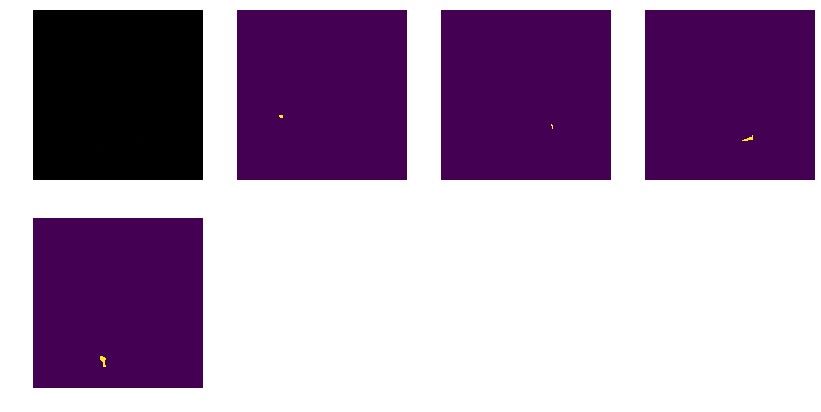

In [12]:
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], nb_fig))])

## Anchors

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts. 
* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row. 
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

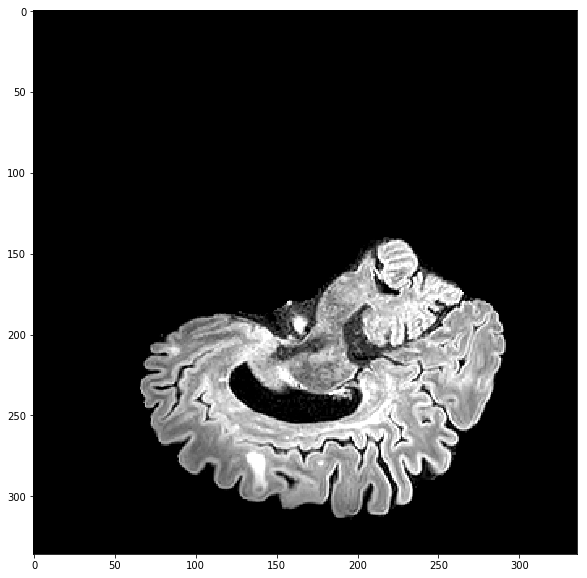

In [13]:
#image_id=369
image = dataset.load_image(image_id)
#mask, class_ids = dataset_train.load_mask(image_id)
#print(class_ids.shape)
#visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=1)

fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)

backbone_shape shape :  (5, 2)
backbone_shape :  [[96 96]
 [48 48]
 [24 24]
 [12 12]
 [ 6  6]]
Count:  36828
Scales:  (16, 32, 64, 128, 256)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 27648
Anchors in Level 1: 6912
Anchors in Level 2: 1728
Anchors in Level 3: 432
Anchors in Level 4: 108
Level 0. Anchors:  27648  Feature map Shape: [96 96]
Level 1. Anchors:   6912  Feature map Shape: [48 48]
Level 2. Anchors:   1728  Feature map Shape: [24 24]
Level 3. Anchors:    432  Feature map Shape: [12 12]
Level 4. Anchors:    108  Feature map Shape: [6 6]


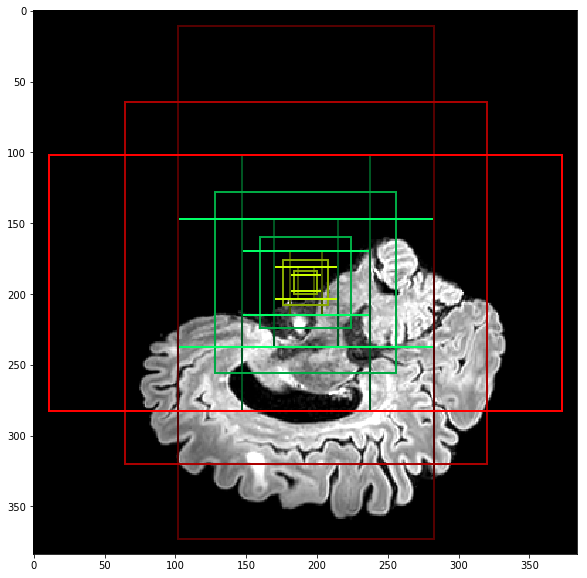

In [14]:
import matplotlib.patches as patches

## Visualize anchors of one cell at the center of the feature map

# Load and display random image
#image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)

# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, image.shape)
# shapes of features maps
print("backbone_shape shape : ", backbone_shapes.shape)
print("backbone_shape : ", backbone_shapes)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

# Display
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


## Data Generator

In [15]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=5,
    detection_targets=True)

In [16]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
#print("toto : ", mrcnn_class_ids)
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (5, 200, 4)           min:    2.00000  max:  383.00000  int32
mrcnn_class_ids          shape: (5, 200, 1)           min:    0.00000  max:    1.00000  int32
mrcnn_bbox               shape: (5, 200, 2, 4)        min:   -3.31938  max:    3.12500  float32
mrcnn_mask               shape: (5, 200, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (5, 100)              min:    0.00000  max:    1.00000  int32
gt_boxes                 shape: (5, 100, 4)           min:    0.00000  max:  326.00000  int32
gt_masks                 shape: (5, 56, 56, 100)      min:    0.00000  max:    1.00000  bool
rpn_match                shape: (5, 36828, 1)         min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (5, 256, 4)           min:   -6.63701  max:    2.65165  float64
image_id:  826 /floyd/input/miccai_preprocess/01016SACH/3DFLAIR_130.nii.gz


anchors                  shape: (36828, 4)            min: -181.01934  max:  501.01934  float64
refined_anchors          shape: (4, 4)                min:  139.00000  max:  297.00000  float32
Positive anchors: 4
Negative anchors: 252
Neutral anchors: 36572
BG                     : 173
Lesion                 : 27


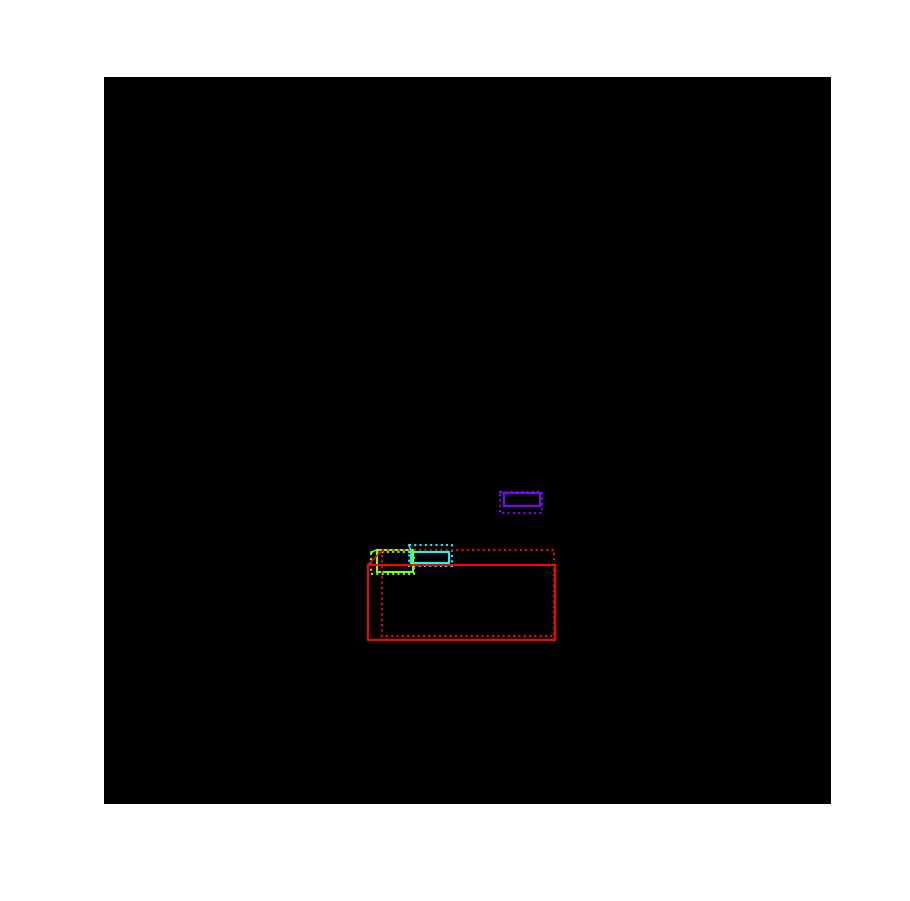

In [17]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)


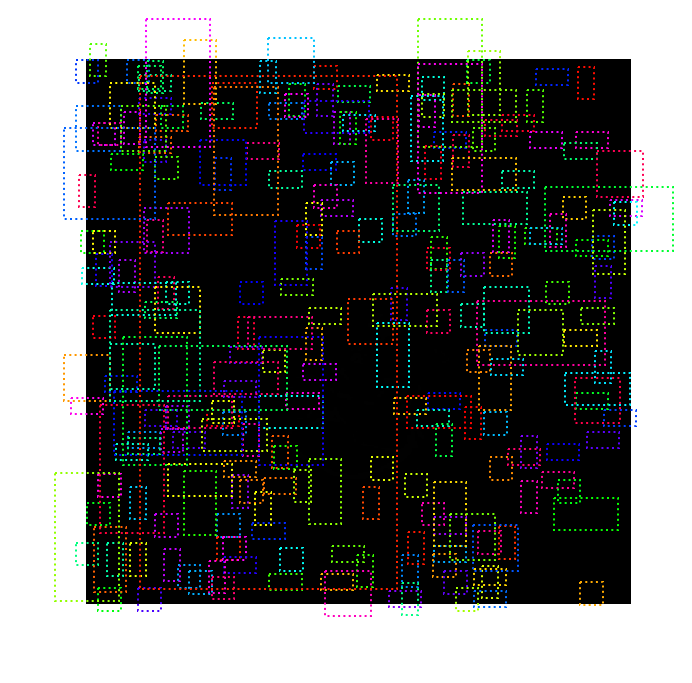

In [19]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

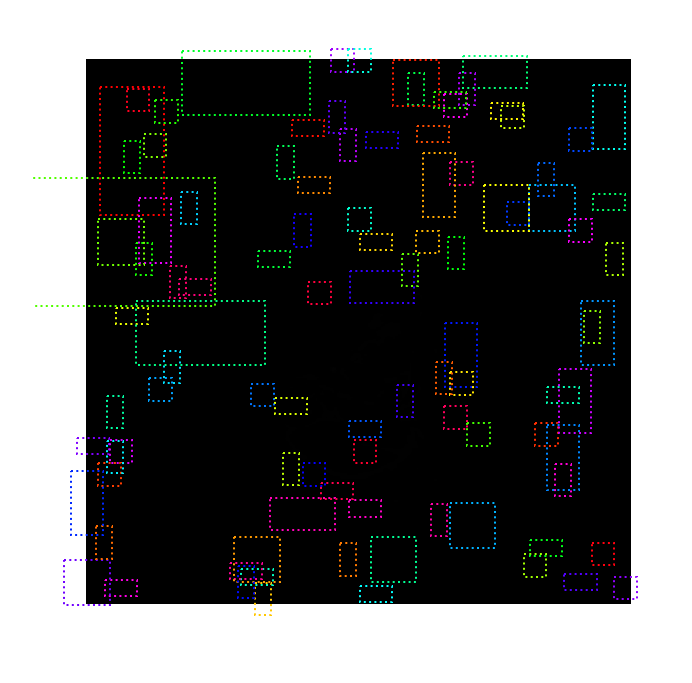

In [20]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

Typically, the RPN network generates region proposals (a.k.a. Regions of Interest, or ROIs). The data generator has the ability to generate proposals as well for illustration and testing purposes. These are controlled by the `random_rois` parameter.

Positive ROIs:  27
Negative ROIs:  173
Positive Ratio: 0.14
Unique ROIs: 199 out of 200


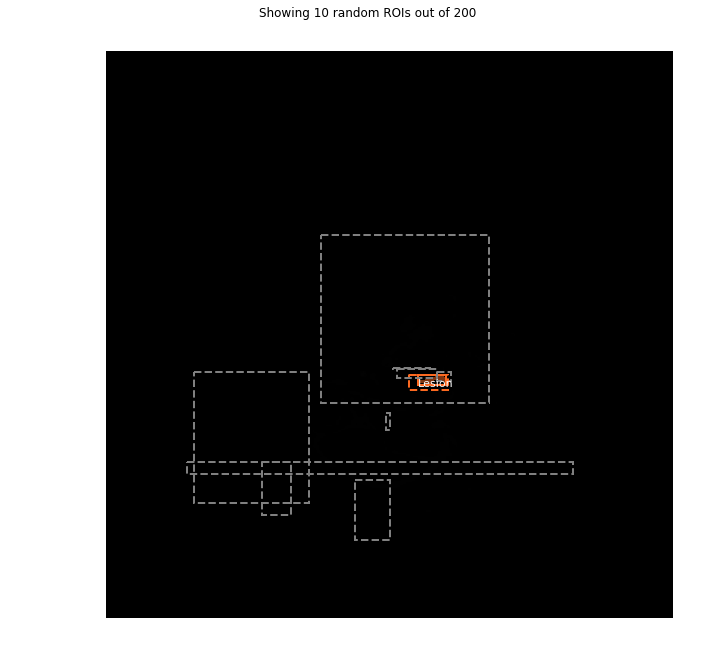

In [21]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

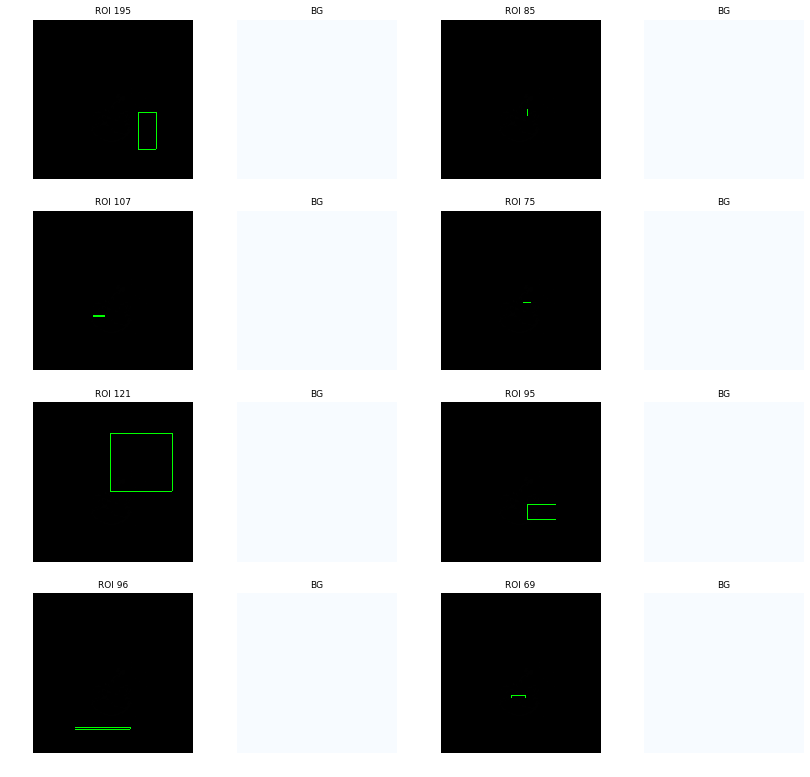

In [22]:
import random
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [23]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=5, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
Average percent: 0.33
